-----------------------------------------
Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру (*Ага, щаз!*).

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам.

---------------------------

Импортируем необходимые для анализа библиотеки и прочитаем наш файл:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings; warnings.simplefilter('ignore') # игнор "предупреждалок"

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

sns.set() # это для более красивых графиков

stud = pd.read_csv('stud_math.csv')

Для начала посмотрим с какой информацием нам предстоит иметь дело:

In [2]:
display(stud.head())
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

М..да... Большая табличка. Итак, у нас имеется 30 колонок с различными данными. 17 колонок с строковыми величинами и остальные (13) - с числовыми.

1. school — аббревиатура школы, в которой учится ученик
2. sex — пол ученика ('F' - женский, 'M' - мужской)
3. age — возраст ученика (от 15 до 22)
4. address — тип адреса ученика ('U' - городской, 'R' - за городом)
5. famsize — размер семьи('LE3' <= 3, 'GT3' >3)
6. Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. schoolsup — дополнительная образовательная поддержка (yes или no)
17. famsup — семейная образовательная поддержка (yes или no)
18. paid — дополнительные платные занятия по математике (yes или no)
19. activities — дополнительные внеучебные занятия (yes или no)
20. nursery — посещал детский сад (yes или no)
21. studytime, granular — непонятный столбик с отрицательными значениями
22. higher — хочет получить высшее образование (yes или no)
23. internet — наличие интернета дома (yes или no)
24. romantic — в романтических отношениях (yes или no)
25. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
26. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
27. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
28. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
29. absences — количество пропущенных занятий
30. score — баллы по госэкзамену по математике

Задача такая: будем искать зависимости между непонятными пока значениями в колонках на значения в самой крайней справа колонке - score. То есть, посмотрим влияние каких параметров сказывается на результат экзамена по математие.

Посмотрим сначала на так уж важный для нас столбец score:

In [3]:
stud.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

In [2]:
stud.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

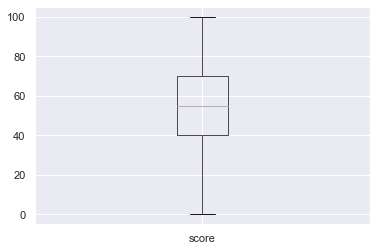

In [4]:
boxplot = stud.boxplot(column = ['score'])
stud.score.describe()

Вот это поворот! Оказывается есть ученики, которые скорее всего вообще не сдавали экзамен и есть пропуски в данных. Возможно пропуски связаны с некорректным заполнением таблицы. 

Как быть? Можно было бы заменить пропуски на, например, значение медианы. Но делать я этого не буду. Дело в том, что это всё равно будет некорректным значением - мы всего лишь предполагаем, а реальное значение могло быть в диапазоне от нуля до ста процентов. Более того, я хочу избавиться и от тех строк, где значение равно нулю. Ну зачем мне обрабатывать тех, кто вообще не сдавал экзамен (*Из будущего - на самом деле, я уже проверил всё это и нулевые значения в большинстве случаев - вылеты*).


In [5]:
stud = stud.loc[stud.score > 0]
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               352 non-null    object 
 1   sex                  352 non-null    object 
 2   age                  352 non-null    int64  
 3   address              338 non-null    object 
 4   famsize              328 non-null    object 
 5   Pstatus              311 non-null    object 
 6   Medu                 350 non-null    float64
 7   Fedu                 331 non-null    float64
 8   Mjob                 335 non-null    object 
 9   Fjob                 320 non-null    object 
 10  reason               337 non-null    object 
 11  guardian             323 non-null    object 
 12  traveltime           329 non-null    float64
 13  studytime            345 non-null    float64
 14  failures             332 non-null    float64
 15  schoolsup            343 non-null    obj

count    352.000000
mean      57.755682
std       16.200928
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

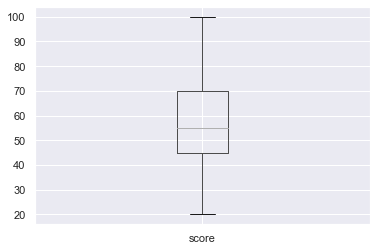

In [6]:
boxplot = stud.boxplot(column = ['score'])
stud.score.describe()

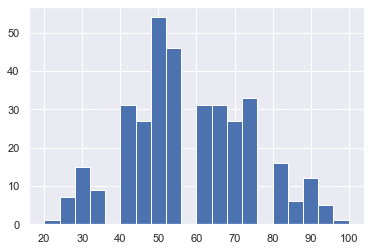

In [7]:
stud.score.hist(bins = 20)

Ну вот! Другое дело. У нас теперь список из 352-х учеников. Диапазон оценок от 20 до 100 баллов. Медиана осталась той же - 55. Характеристика распределения параметра смещена вправо. Явно, что прям уж отличников гораздо меньше, чем середнячков.

Хорошо. А теперь посмотрим сколько школ представлено в нашей таблице и количество учеников в них: 

In [9]:
stud.school.unique()

array(['GP', 'MS'], dtype=object)

In [10]:
pd.DataFrame(stud.school.value_counts())

,school
GP,311
MS,41


Вот оно чо, Михалыч! В школе GP учащихся в семь с половиной раз больше! Интересно. Посморим на распределение оценов в этих школах:

In [11]:
# создадим два датасета:

GP_stud = stud.loc[stud.school == 'GP']
MS_stud = stud.loc[stud.school == 'MS']

#### Школа GP:

count    311.000000
mean      58.215434
std       16.282245
min       20.000000
25%       47.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

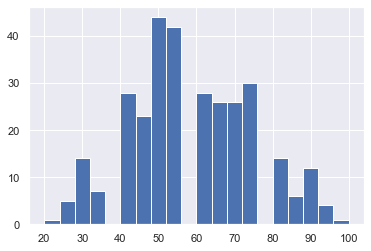

In [12]:
GP_stud.score.hist(bins = 20)
GP_stud.score.describe()

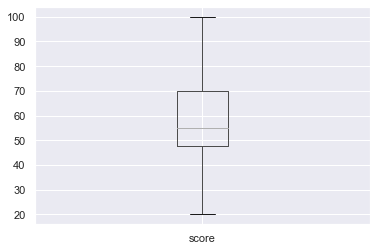

In [13]:
boxplot = GP_stud.boxplot(column=['score'])

Распределение смещено вправо с телом значений, лежащим в диапазоне (Q1-Q3) 47.5 .. 70 баллов и медианой 55 баллов.

####  Школа MS:

count    41.000000
mean     54.268293
std      15.311800
min      25.000000
25%      45.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

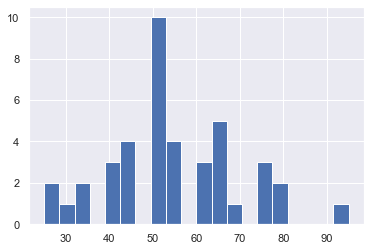

In [14]:
MS_stud.score.hist(bins = 20)
MS_stud.score.describe()

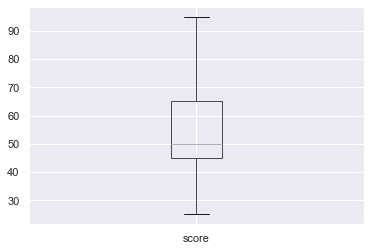

In [15]:
boxplot = MS_stud.boxplot(column=['score'])

Распределение смещено вправо с телом значений, лежащим в диапазоне (Q1-Q3) 45 .. 65 баллов и медианой 50 баллов.

Сразу проверим ещё процент отличников(балл больше или равен 80) в школах:

In [26]:
GP_over80 = GP_stud[GP_stud.score >= 80]
GP_over80.score.count()
GP_stud.score.count()

print(round(((GP_over80.score.count() * 100) / (GP_stud.score.count())), 1),
      'процентов отличников в школе GP')


MS_over80 = MS_stud[MS_stud.score >= 80]
MS_over80.score.count()
MS_stud.score.count()

print(round(((MS_over80.score.count() * 100) / (MS_stud.score.count())), 1),
      'процентов отличников в школе MS')

11.9 процентов отличников в школе GP
7.3 процентов отличников в школе MS


------------------------
*Теперь можно сказать следущее: школа GP горяздо больше школы MS. Вцелом, учащиеся школы GP лучше сдали экзамен.
Возможно, GP - это крупная школа с сильным преподавательским составом.*

---------------------

А может быть школы GP и MS - это гендерно ориентированные школы (то есть раздельные для мальчиков и девочек)?.. Проверим это. 

----------------------------------------------------------------
## sex

Звучит интригующе, однако, это всего лишь колонка с указанием пола учащегося. Хоть пропусков нет..

----------------------------------------------------

Проверим, что указано два пола и нет всяких непонятных "либо-либо" значений. Толерантность - не мой конёк:

In [27]:
stud.sex.unique()

array(['F', 'M'], dtype=object)

Ура! Всё хорошо - только мальчики и девочки!

Так что же всё-таки с нашими школами:

In [28]:
GP_stud.sex.unique()

array(['F', 'M'], dtype=object)

In [29]:
MS_stud.sex.unique()

array(['M', 'F'], dtype=object)

Всё нормально - школы как школы. Совместное обучение мальчиков и девочек.
Не буду привязывать анализ успехов мальчиков и девочек к каждой школе.

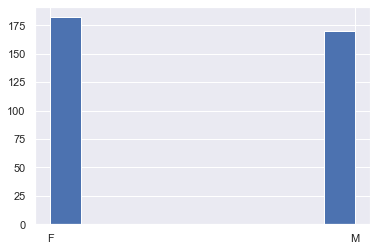

In [30]:
stud.sex.hist()

Так. Девочек чуть больше чем мальчиков.

Сначала посмотрим на мальчиков (не связано с каким-либо ущемллением, защемлением или прищемлением прав женщин):

count    170.000000
mean      59.470588
std       16.318275
min       25.000000
25%       50.000000
50%       60.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

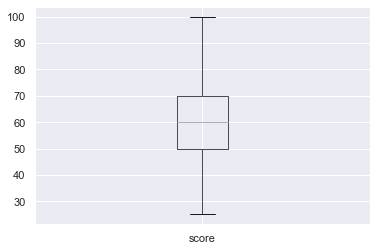

In [31]:
stud_m = stud.loc[stud.sex == 'M']
boxplot = stud_m.boxplot(column = ['score'])
stud_m.score.describe()

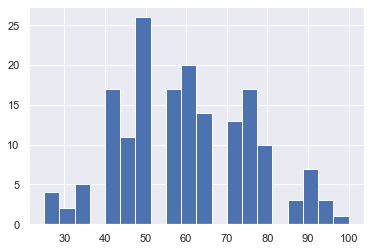

In [32]:
stud_m.score.hist(bins = 20)

Нормальное распределение с телом значений в диапазоне 50..70 баллов и медианой 60 баллов.

А теперь девочки:

count    182.000000
mean      56.153846
std       15.969185
min       20.000000
25%       45.000000
50%       55.000000
75%       68.750000
max       95.000000
Name: score, dtype: float64

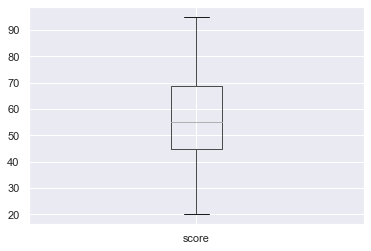

In [33]:
stud_f = stud.loc[stud.sex == 'F']
boxplot = stud_f.boxplot(column = ['score'])
stud_f.score.describe()

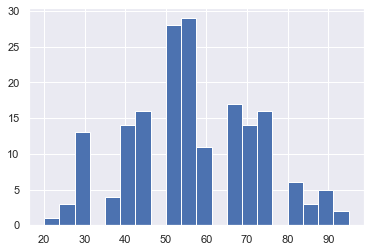

In [34]:
stud_f.score.hist(bins = 20)

Особых отличий вроде и нет - нормальное распределение с телом значений в диапазоне 45..69 баллов и медианой 50 баллов. Ну чуть хуже.
Интересно посмотреть на ещё один график:

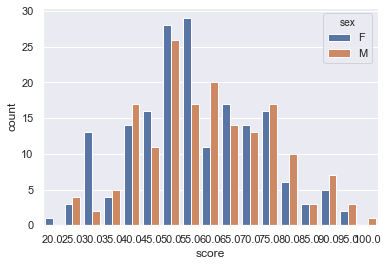

In [35]:
sns.countplot(x = 'score', hue = 'sex', data = stud)

Вот теперь уже видно, что девочки на самом деле чуть хуже сдали экзамен, хотя, диапазон оценок 45..55 девочкам дался лучше чем мальчикам.
Посмотрим на процент отличников (балл больше или равен 80):

In [36]:
m_over80 = stud_m[stud_m.score >= 80]
m_over80.score.count()
stud_m.score.count()

print(round(((m_over80.score.count() * 100) / (stud_m.score.count())), 1),
      'процентов отличников среди мальчиков')


f_over80 = stud_f[stud_f.score >= 80]
f_over80.score.count()
stud_f.score.count()

print(round(((f_over80.score.count() * 100) / (stud_f.score.count())), 1),
      'процентов отличников среди девочек')

14.1 процентов отличников среди мальчиков
8.8 процентов отличников среди девочек


Ну вот ещё одно подтверждение того, что в рассматриваемых школах мальчики чуть лучше сдали экзамен чем девочки. Однако, прилежны учеников (диапазон баллов 45..55) больше среди девочек.

----------------------------

## age

Добрались до возраста. Посмотрим распределение параметра:

-------------------------------

count    352.000000
mean      16.633523
std        1.256011
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

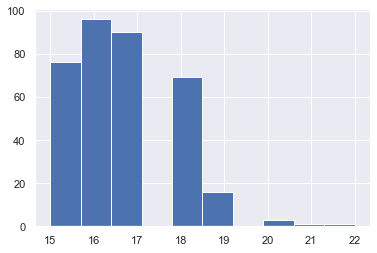

In [37]:
stud.age.hist()
stud.age.describe()

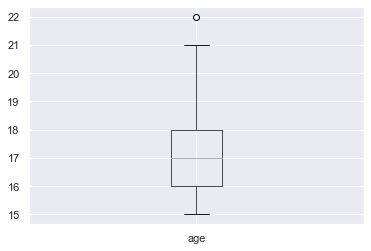

In [39]:
boxplot = stud.boxplot(column = ['age'])

Итак, у нас весьма широкий диапазон значений возрастов - от 15-ти до 22-х лет. 22 года - выброс. Распределение смещено вправо. Тело значений (Q1-Q3) лежит в диапазоне 16..18 лет. Медиана - 17 лет.

Посмотрим ещё на один график распределения оценок по возрастам:

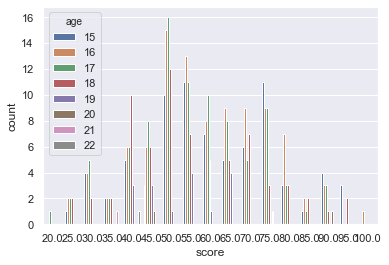

In [42]:
sns.countplot(x = 'score', hue = 'age', data = stud)

Не совсем понятно, поэтому проведём корреляционный анализ:

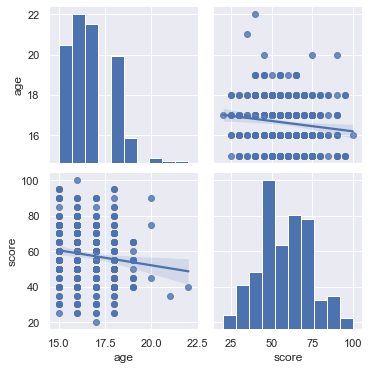

In [43]:
age_score = stud[['age', 'score']]
sns.pairplot(age_score, kind = 'reg')

In [44]:
# матрица корреляции:
age_score.corr()

,age,score
age,1.000000,-0.131542
score,-0.131542,1.000000


Хорошо. Теперь можно сказать, что зависимость от возраста есть, хоть и не сильная. С увеличением возраста учащихся падает значение оценки за экзамен. Лучше себя чувствуют ученики 16..18 лет.

--------------------------------
## address

Подошли к месту жительства учащихся. В этом столбике содержатся даные о месте жительства - городской или селянин. Предполагаю, что в таблице заложено, что "селяне" немного глупее (стереотип). Проверим это. Но сначала, заменим пропуски на None:

------------------

In [46]:
stud.address = stud.address.astype(str).apply(lambda x: None if x.strip() == '' else x)

Посмотрим на распределение признака:

count     352
unique      3
top         U
freq      265
Name: address, dtype: object

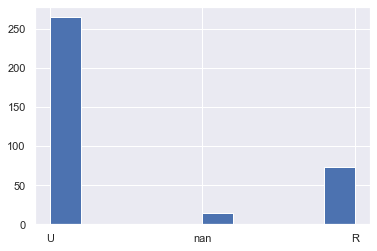

In [47]:
stud.address.hist()
stud.address.describe()

Итак, очевидно явное преобладание городских жителей. Проверим их успехи:

count    265.000000
mean      58.830189
std       16.182828
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

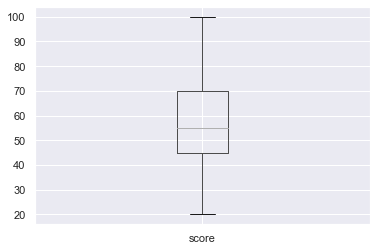

In [49]:
stud_urban = stud.loc[stud.address == 'U']
boxplot = stud_urban.boxplot(column = ['score'])
stud_urban.score.describe()

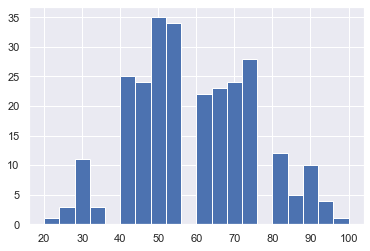

In [50]:
stud_urban.score.hist(bins = 20)

Немного смещённая вправо характеристика с телом параметров в диапазоне 45..70 баллов и медианой 55 баллов. Очень хороший результат - стабильно хороший. 

А теперь посмотрим на результат немногочисленных селян (хотя, это могут быть жители гигантских многомиллионных особняков :-) )

count    73.000000
mean     53.356164
std      16.203026
min      25.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

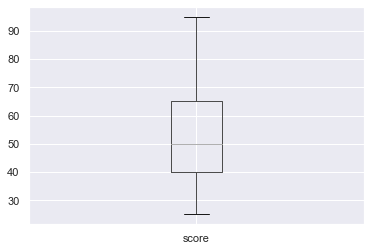

In [51]:
stud_rural = stud.loc[stud.address == 'R']
boxplot = stud_rural.boxplot(column = ['score'])
stud_rural.score.describe()

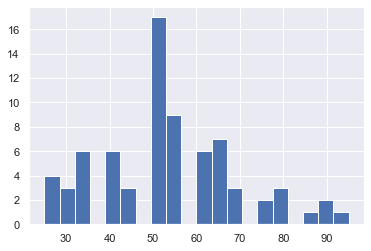

In [52]:
stud_rural.score.hist(bins = 20)

Также смещённая вправо характеристика с телом параметров в диапазоне 40..65 баллов и медианой 50 баллов.

Для окончательного вывода посмотим на процент отличников (балл больше или равен 80):

In [54]:
urban_over80 = stud_urban[stud_urban.score >= 80]
urban_over80.score.count()
stud_urban.score.count()

print(round(((urban_over80.score.count() * 100) / (stud_urban.score.count())), 1),
      'процентов отличников среди горожан')


rural_over80 = stud_rural[stud_rural.score >= 80]
rural_over80.score.count()
stud_rural.score.count()

print(round(((rural_over80.score.count() * 100) / (stud_rural.score.count())), 1),
      'процентов отличников среди селян')

12.1 процентов отличников среди горожан
9.6 процентов отличников среди селян


Получается, что горожане и вправду сдают экзамен чуть лучше, чем селяне. Но скорее всего это связано с общим малым числом наблюдений. Горожан 265 человек, а селян всего 73.

---------------------

## famsize

Размер семьи. Всего два параметра: три и менее человек в семье и больше трёх.

In [55]:
# Пропуски сразу меняем на None:
stud.famsize = stud.famsize.astype(str).apply(lambda x: None if x.strip() == '' else x)

Распределение признака:

count     352
unique      3
top       GT3
freq      228
Name: famsize, dtype: object

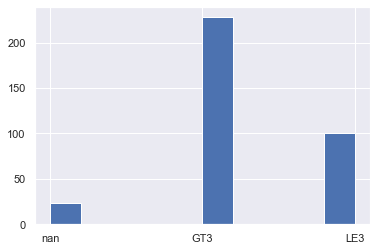

In [56]:
stud.famsize.hist()
stud.famsize.describe()

Видим, что в обеих школах превалируют ученики из больших (более или равно трём членов) семей. Посмотрим на оценки:

count    228.000000
mean      57.609649
std       16.097481
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

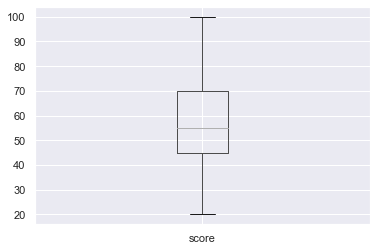

In [61]:
stud_GT3 = stud.loc[stud.famsize == 'GT3']
boxplot = stud_GT3.boxplot(column = ['score'])
stud_GT3.score.describe()

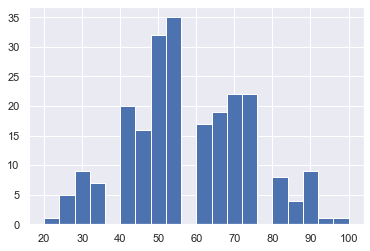

In [58]:
stud_GT3.score.hist(bins = 20)

Тело значений лежит в диапазоне 45..70 баллов с медианой 55 баллов. Распределение немного смещено вправо.

Теперь посмотрим на "малодетных":

count    100.000000
mean      58.500000
std       16.197955
min       25.000000
25%       48.750000
50%       57.500000
75%       70.000000
max       95.000000
Name: score, dtype: float64

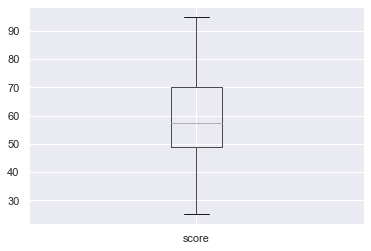

In [62]:
stud_LE3 = stud.loc[stud.famsize == 'LE3']
boxplot = stud_LE3.boxplot(column = ['score'])
stud_LE3.score.describe()

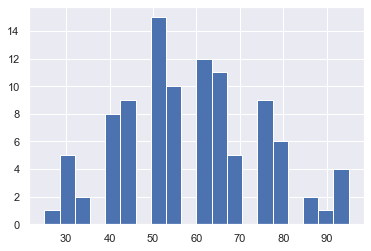

In [63]:
stud_LE3.score.hist(bins = 20)

Практически та же картина: тело значений лежит в диапазоне 49..70 баллов с медианой 57 баллов. Распределение немного смещено вправо.

По традиции, посмотрим на количество отличников:

In [64]:
GT3_over80 = stud_GT3[stud_GT3.score >= 80]
GT3_over80.score.count()
stud_GT3.score.count()

print(round(((GT3_over80.score.count() * 100) / (stud_GT3.score.count())), 1),
      'процентов отличников среди многодетных')


LE3_over80 = stud_LE3[stud_LE3.score >= 80]
LE3_over80.score.count()
stud_LE3.score.count()

print(round(((LE3_over80.score.count() * 100) / (stud_LE3.score.count())), 1),
      'процентов отличников среди малодетных')

10.1 процентов отличников среди многодетных
13.0 процентов отличников среди малодетных


Вот как. Получается весьма резонный результат. В небольших семьях детям уделяется больше внимания, соответственно, лучше готовятся домашние задания. Вот и результат.

---------------------------------
## Pstatus

Статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

--------------------------------

count     352
unique      3
top         T
freq      277
Name: Pstatus, dtype: object

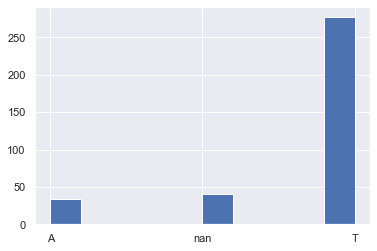

In [66]:
# Пропуски сразу меняем на None:
stud.Pstatus = stud.Pstatus.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.Pstatus.hist()
stud.Pstatus.describe()

Посмотрим на оценки:

count    277.000000
mean      57.490975
std       15.906341
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

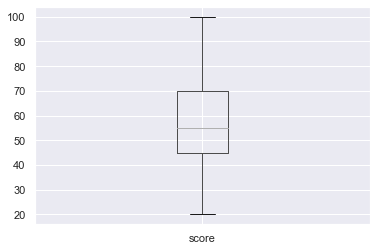

In [67]:
stud_T = stud.loc[stud.Pstatus == 'T']
boxplot = stud_T.boxplot(column = ['score'])
stud_T.score.describe()

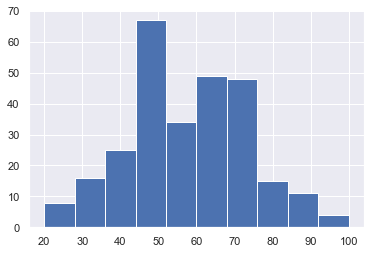

In [70]:
stud_T.score.hist()

count    34.000000
mean     58.382353
std      18.245821
min      30.000000
25%      46.250000
50%      55.000000
75%      68.750000
max      95.000000
Name: score, dtype: float64

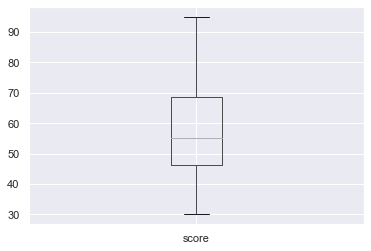

In [71]:
stud_A = stud.loc[stud.Pstatus == 'A']
boxplot = stud_A.boxplot(column = ['score'])
stud_A.score.describe()

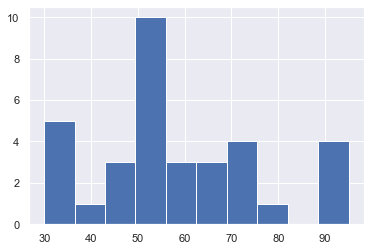

In [72]:
stud_A.score.hist()

Для этого параметра ожидал увидеть явное преимущество одного из факторов. Однако, такого не произошло. Обе характеристики - смещённые вправо с медианой в 55 баллов. Диапазон значений примерно одинаков. Дети, у которых оба родителя живут вместе учатся как обычно - характеристика "пирамидкой" Есть и отстающие, есть и вундеркинды.

Для детей, у которых родители живут врозь характерна более пологая - распределённая по всей оси характеристика. И скорее всего, оценка больше зависит от того, с кем из родителей остался ребёнок. А точнее - от характеристик самого родителя. Поэтому, этот параметр я бы не стал брать в расчёт для прогноза оценки.

---------------------------------

## schoolsup 

Дополнительная образовательная поддержка (yes или no)

--------------------------------

count     352
unique      3
top        no
freq      295
Name: schoolsup, dtype: object

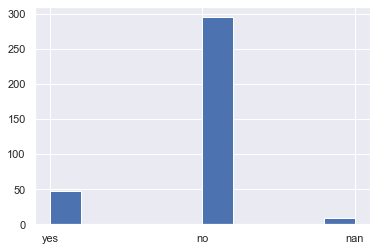

In [73]:
# Пропуски сразу меняем на None:
stud.schoolsup = stud.schoolsup.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.schoolsup.hist()
stud.schoolsup.describe()

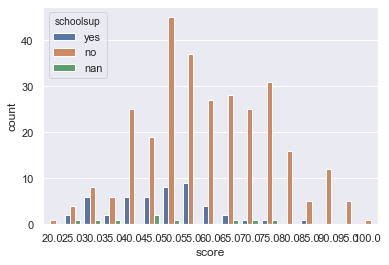

In [74]:
sns.countplot(x = 'score', hue = 'schoolsup', data = stud)

Странно, но дополнительная образовательная поддержка не помогла. Все ученики, которым эта поддержка была предназначена, сдали экзамен не очень хорошо.

Так что, если такая поддержка была нужна (а я так понял, что это что-то вроде работы с отстающими учениками), то ожидать высокой оценки не приходится. То есть, использовать этот параметр для прогноза - будет полезно.

------------------------------
## famsup

Семейная образовательная поддержка (yes или no)

-----------------

count     352
unique      3
top       yes
freq      196
Name: famsup, dtype: object

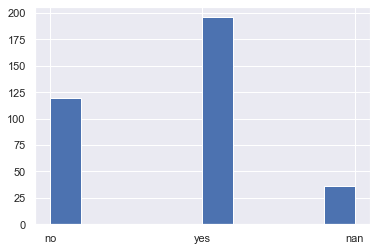

In [75]:
# Пропуски сразу меняем на None:
stud.famsup = stud.famsup.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.famsup.hist()
stud.famsup.describe()

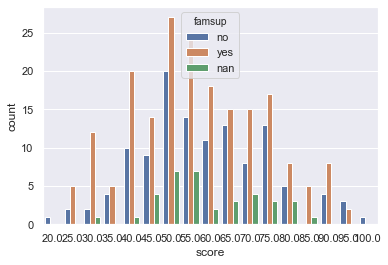

In [76]:
sns.countplot(x = 'score', hue = 'famsup', data = stud)

count    196.000000
mean      56.989796
std       16.706206
min       25.000000
25%       45.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

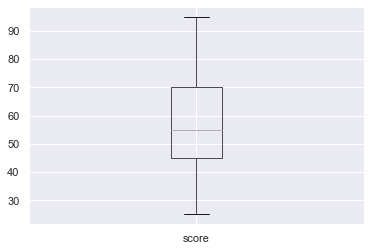

In [77]:
stud_fam_y = stud.loc[stud.famsup == 'yes']
boxplot = stud_fam_y.boxplot(column = ['score'])
stud_fam_y.score.describe()

count    120.000000
mean      58.583333
std       16.246310
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

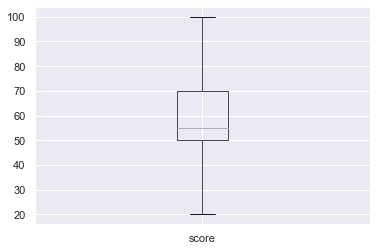

In [78]:
stud_fam_n = stud.loc[stud.famsup == 'no']
boxplot = stud_fam_n.boxplot(column = ['score'])
stud_fam_n.score.describe()

Вот сейчас другое дело! Видно, что существует явное положительное влияние такой поддержки на результат по экзамену. Поддержка пришлась кстати. Характеристики практически одинаковы. А поэтому, была поддержка или её не было - на прогноз оценки это не влияет.

-----------------------------

## paid 

Дополнительные платные занятия по математике (yes или no).

Вот и посмотрим насколько платные курсы хороши :-)

------------------

count     352
unique      3
top        no
freq      170
Name: paid, dtype: object

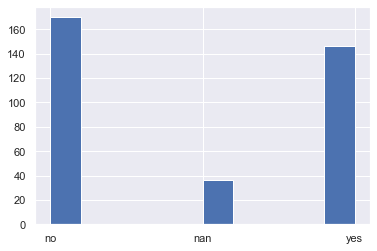

In [80]:
# Пропуски сразу меняем на None:
stud.paid = stud.paid.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.paid.hist()
stud.paid.describe()

Почти половине учеников понадобились такие курсы.

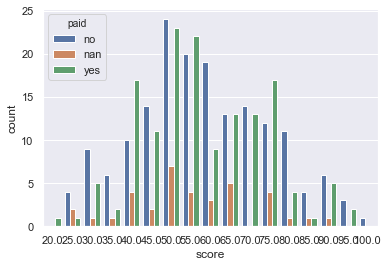

In [81]:
sns.countplot(x = 'score', hue = 'paid', data = stud)

count    146.000000
mean      57.636986
std       15.427195
min       20.000000
25%       46.250000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

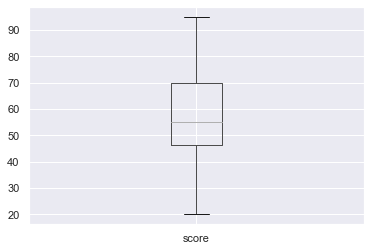

In [82]:
stud_paid_y = stud.loc[stud.paid == 'yes']
boxplot = stud_paid_y.boxplot(column = ['score'])
stud_paid_y.score.describe()

count    170.000000
mean      58.352941
std       16.912378
min       25.000000
25%       46.250000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

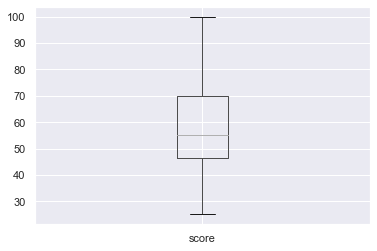

In [83]:
stud_paid_n = stud.loc[stud.paid == 'no']
boxplot = stud_paid_n.boxplot(column = ['score'])
stud_paid_n.score.describe()

Как и в случае с семейной поддержкой, такие курсы нивелировали шансы всех учеников на получение хорошей оценки.

Так что, и этот параметр не подходит для прогноза.

----------------------

## activities

Дополнительные внеучебные занятия (yes или no)

Как я понимаю, это любые занятия - будь то кружок ройки и шитья или секция бокса - то есть, дополнительная нагрузка.

---------------------------

count     352
unique      3
top       yes
freq      172
Name: activities, dtype: object

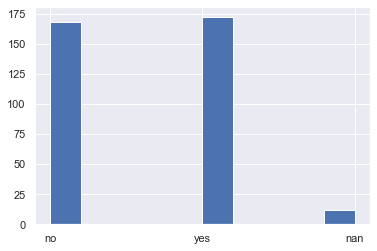

In [84]:
# Пропуски сразу меняем на None:
stud.activities = stud.activities.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.activities.hist()
stud.activities.describe()

Почти каждый второй занимается чем-то после школы.

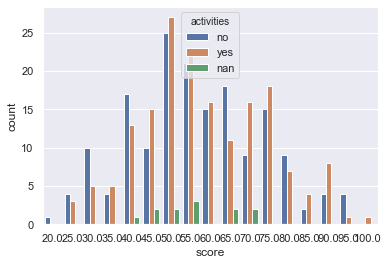

In [85]:
sns.countplot(x = 'score', hue = 'activities', data = stud)

count    172.000000
mean      58.808140
std       16.064684
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

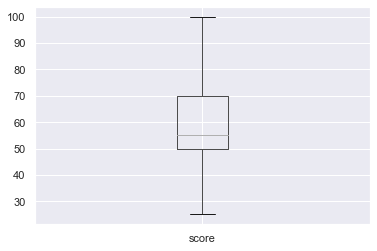

In [86]:
stud_act_y = stud.loc[stud.activities == 'yes']
boxplot = stud_act_y.boxplot(column = ['score'])
stud_act_y.score.describe()

count    168.000000
mean      56.845238
std       16.682663
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

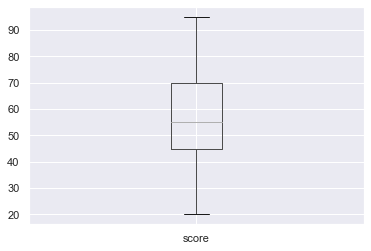

In [87]:
stud_act_n = stud.loc[stud.activities == 'no']
boxplot = stud_act_n.boxplot(column = ['score'])
stud_act_n.score.describe()

Итак. Этот параметр также не оказывает влияния на результат экзамена. 

--------------------------------------------
## nursery 

Посещал детский сад (yes или no)

Даже и проверять не буду этот столбик. Детския сад - это для 15-20-ти летних "детей" уже явно далёкое прошлое, которое если и оказывало влияние на что-то, то только в первый год школы в качестве адаптации к режиму.

---------------------------------------

----------------------------------

## higher

Хочет получить высшее образование (yes или no).

А вот это интересный столбик. Проверим его.

------------------------

count     352
unique      3
top       yes
freq      320
Name: higher, dtype: object

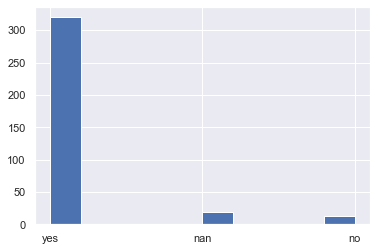

In [88]:
# Пропуски сразу меняем на None:
stud.higher = stud.higher.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.higher.hist()
stud.higher.describe()

...М..да... Так получилось, что желают почти все. Можно проверить тогда насколько всё плохо у тех, кто не хочет ВО.

count    13.000000
mean     49.230769
std       9.540736
min      35.000000
25%      40.000000
50%      50.000000
75%      60.000000
max      65.000000
Name: score, dtype: float64

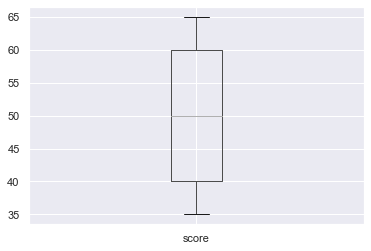

In [89]:
stud_higher_n = stud.loc[stud.higher == 'no']
boxplot = stud_higher_n.boxplot(column = ['score'])
stud_higher_n.score.describe()

Как видим, тело лежит в диапазоне 40..60 баллов с медианой 50 баллов. Вполне нормальное распределение.
Так что, этот параметр можно исользовать только в том случае, если будет идти прогноз на получение оценки выше 60..65 баллов.


---------------------------

## internet

Наличие интернета дома (yes или no).

Ещё один интересный параметр. Ведь наличие интернета может сказаться как положительно, так и отрицательно.

Посмотрим.

-----------------------------

count     352
unique      3
top       yes
freq      274
Name: internet, dtype: object

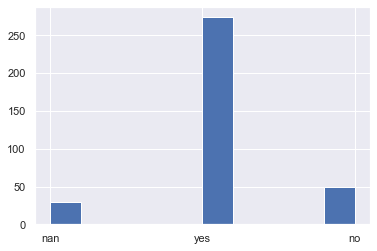

In [90]:
# Пропуски сразу меняем на None:
stud.internet = stud.internet.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.internet.hist()
stud.internet.describe()

Хм... Та же история, что и с желанием получить "вышку". Инет есть практически у всех. Но для своего успокоения проверим тех, у кого интернета дома нет:

count    49.000000
mean     55.102041
std      14.415335
min      30.000000
25%      45.000000
50%      55.000000
75%      65.000000
max      90.000000
Name: score, dtype: float64

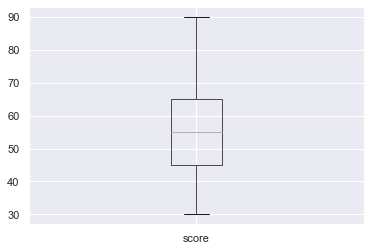

In [91]:
stud_internet_n = stud.loc[stud.internet == 'no']
boxplot = stud_internet_n.boxplot(column = ['score'])
stud_internet_n.score.describe()

Практически нормальное распределение. А оценки в диапазоне от 30 до 90 баллов! То есть, отсутствие интернета дома никак не влияет на оценку.

-----------------------------------

## romantic

В романтических отношениях (yes или no).

Даже и не знаю как к этой информации относиться... Но посмотрим что там:

-----------------

count     352
unique      3
top        no
freq      219
Name: romantic, dtype: object

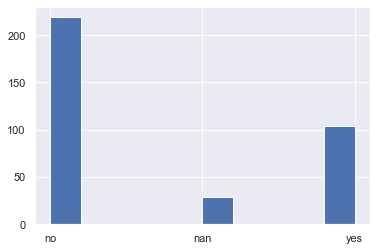

In [92]:
# Пропуски сразу меняем на None:
stud.romantic = stud.romantic.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.romantic.hist()
stud.romantic.describe()

Чуть больше сотни счастливчиков :)

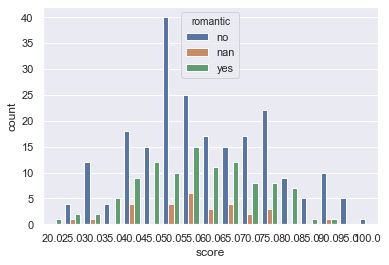

In [93]:
sns.countplot(x = 'score', hue = 'romantic', data = stud)

А что в итоге? А в итоге - "романтики" ничуть не хуже и не лучше "зубрил". Так что, этот параметр не очень то и влияет на прогноз оценки.

-----------------------
## guardian

Опекун ('mother' - мать, 'father' - отец, 'other' - другое).
Не совсем понятно что это, но проверим.

--------------------

count        352
unique         4
top       mother
freq         225
Name: guardian, dtype: object

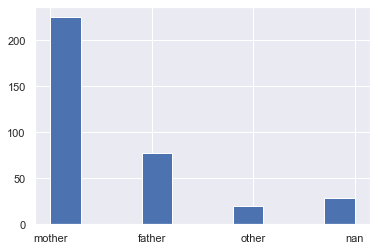

In [134]:
# Пропуски сразу меняем на None:
stud.guardian = stud.guardian.astype(str).apply(lambda x: None if x.strip() == '' else x)

# Распределение признака:
stud.guardian.hist()
stud.guardian.describe()

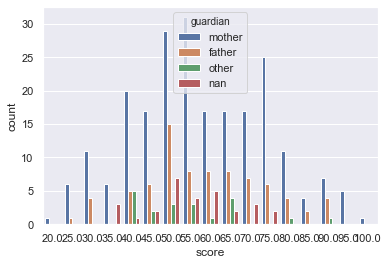

In [135]:
sns.countplot(x = 'score', hue = 'guardian', data = stud)

В-общем, получается, что всё равно кто опекун. По всей видимости, этот параметр не влияет на оценку и не поможет нам для модели предсказания.

----------------

## Анализ номинативных переменных

Номинативные переменные, которые осталось рассмотреть: **Medu, Fedu, Mjob, Fjob, reason, traveltime, studytime, failures, famrel, freetime, goout, health, absences**.



In [114]:
def stud_boxplot(column):
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxplot(x = column, y = 'score',
                data = stud,
                ax = ax)
    plt.xticks(rotation = 45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

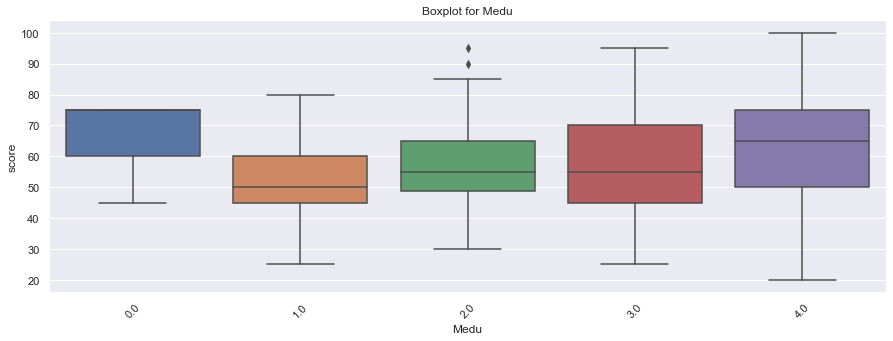

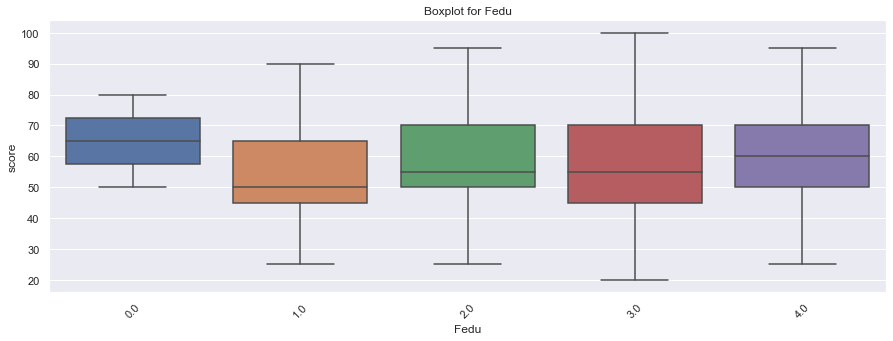

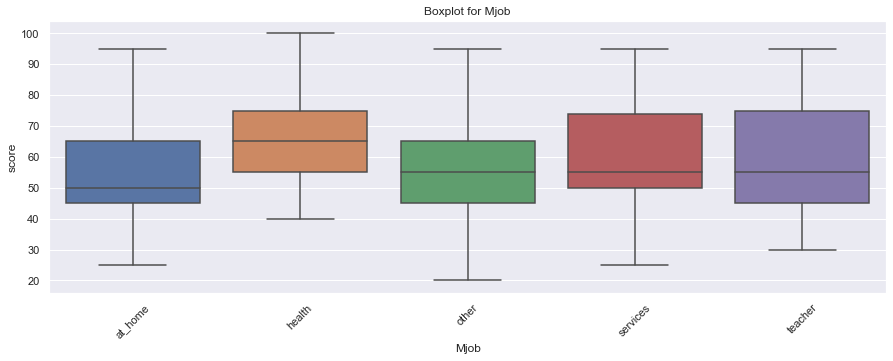

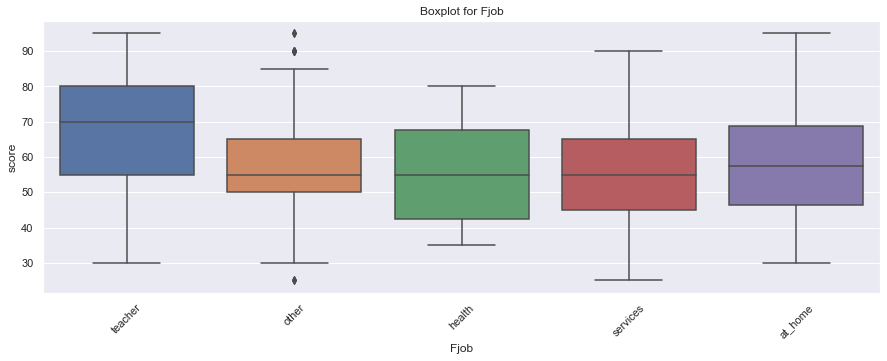

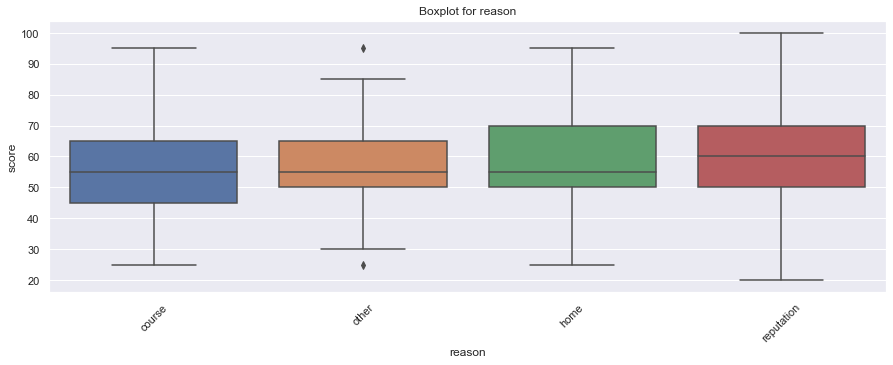

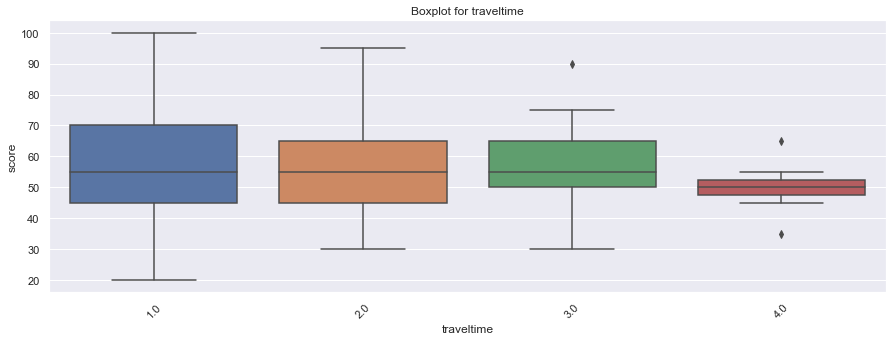

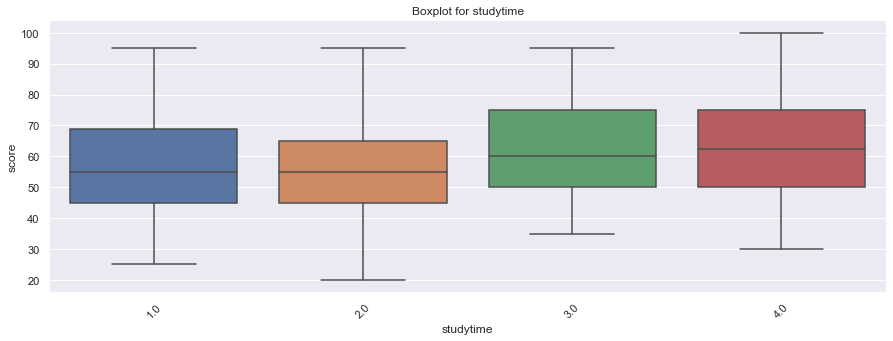

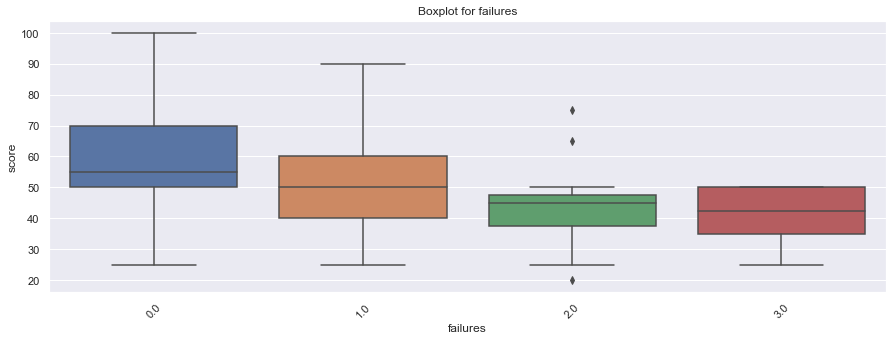

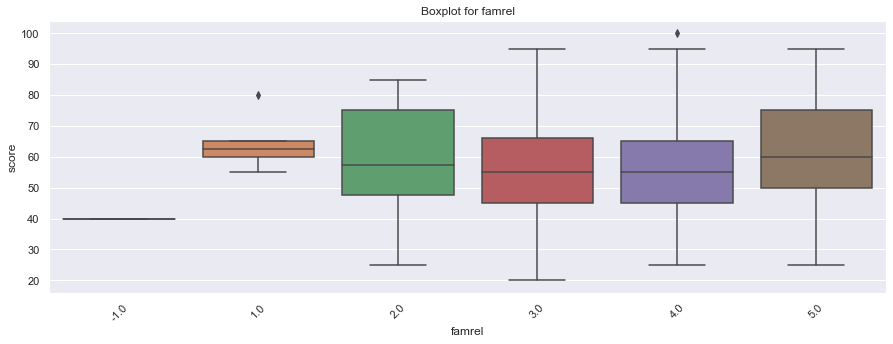

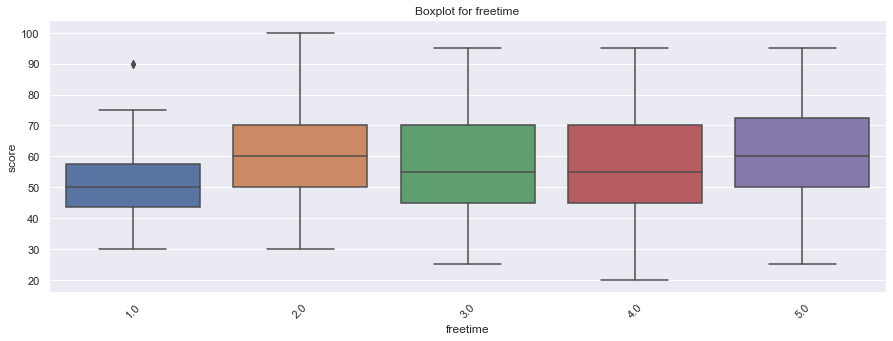

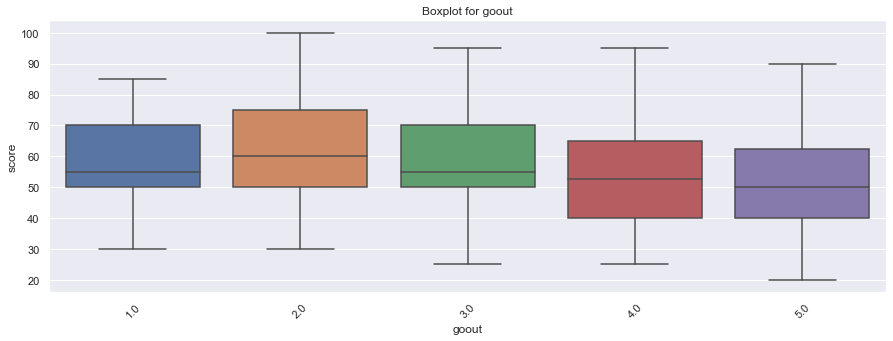

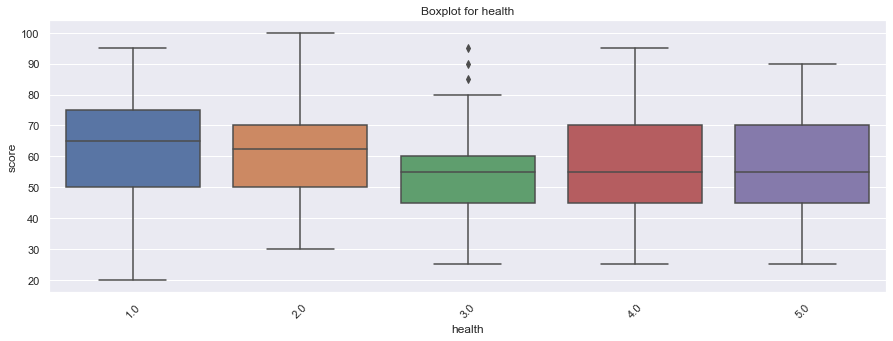

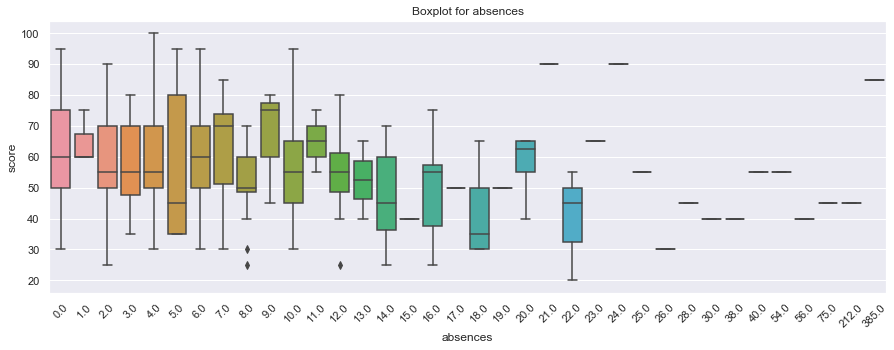

In [116]:
import warnings
warnings.simplefilter('ignore')
sns.set()

stud.Fedu = stud.Fedu.replace(40.0, 4.0) # В таблице была допущена ошибка. Вместо значения 4.0 поставили 40.0

for col in ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures', 
            'famrel', 'freetime', 'goout', 'health', 'absences']:
    stud_boxplot(col)

Красиво получилось. Начнём по-порядку:

**Medu, Fedu** - образование родителей. По медианным значениям виден восходящий тренд. То есть, чем образованней родители, тем шансы получить хорошую оценку у их детей выше.

**Mjob, Fjob** - работа родителей. Здесь бОльшее влияние на хорошую оценку имеют матери с работой в области здравоохранения и отцы, работающие учителями. Странно, но мамы-учителя не имеют такого влияния, как мамы-медики.

**reason** - причина выбора школы очевидным образом никак не влияет на оценку.

**traveltime** - время в пути до школы. Странным образом это влияет на оценку! Возможно, дети устают в пути и не могут сконцентрироваться на занятиях. Тем не менее, очень хорошо видно по диапазону min-max, что чем меньше дети тратят времени на дорогу в школу, тем шанс получить хорошую оценку выше.

**studytime** - время на учёбу помимо школы в неделю. Хоть и не столь явно, но по медианам видна зависимость: чем больше ребёнок тратит времени на учёбу, тем лучше показатель.

**failures** - количество внеучебных неудач. Хоть и не совсем понятно что это такое, но хорошо видно как по медианам, так и по диапазонам min-max, что с увеличением неудач шанс получить хорошую оценку уменьшается.

**famrel** - семейные отношения. И опять. Вполне закономерно, что хорошие отношения в семье - путь к успеху во всём. В том числе, и в получении хорошей оценки.

**freetime** - свободное время после школы. Как видим, только лишь очень малое свободное время влияет на максимальную ценку. значение 2 и более уже не оказывают значимого влияния.

**goout** - проведение времени с друзьями. Интересно, но негативное влияние оказывает как отсутствие времени, проведённого с друзьями, так и излишне частые "гулянки". Оптимальное значение параметра - 2.

**health** - текущее состояние здоровья. Этот параметр интересным образом показывает, что ученики, которые чувствуют себя не очень хорошо (на самом деле просто волнуются во время экзамена) сдают экзамен лучше, чем вполне себе жизнерадостно настроенные и пышащие здоровьем (по их ощущениям) молодые люди. Оптимальное значение этог параметра - 2. То есть, присутствует весьма сильное волнение.

**absences** - количество пропущенных занятий. Довольно интересный столбик. Можно заметить, что с десяток пропусков - практически не влияет на успех. В дальнейшем уже заметна нисходящая зависимость.


*Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения экзаменационных оценок по различным параметрам неразличимы:*

In [132]:
def stud_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [133]:
for col in ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures', 
            'famrel', 'freetime', 'goout', 'health', 'absences']:
    stud_stat_dif(col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


Тест выдал результат, с которым я не очень согласен. Да, подтвердилось влияние некоторых колонок. Однако, всё же оставлю все, кроме столбца *reason*:

In [136]:
stud_for_model = stud.loc[:, ['school', 'sex', 'age', 'address', 'famsize', 'Medu', 'Fedu',
                              'Mjob', 'Fjob', 'traveltime', 'studytime', 'schoolsup', 'studytime',
                              'famrel', 'freetime', 'goout', 'health', 'absences']]
stud_for_model.head()

,school,sex,age,address,famsize,Medu,Fedu,Mjob,Fjob,traveltime,studytime,schoolsup,studytime,famrel,freetime,goout,health,absences
0,GP,F,18,U,nan,4.0,4.0,at_home,teacher,2.0,2.0,yes,2.0,4.0,3.0,4.0,3.0,6.0
1,GP,F,17,U,GT3,1.0,1.0,at_home,other,1.0,2.0,no,2.0,5.0,3.0,3.0,3.0,4.0
2,GP,F,15,U,LE3,1.0,1.0,at_home,other,1.0,2.0,yes,2.0,4.0,3.0,2.0,3.0,10.0
3,GP,F,15,U,GT3,4.0,2.0,health,NaN,1.0,3.0,no,3.0,3.0,2.0,2.0,5.0,2.0
4,GP,F,16,U,GT3,3.0,3.0,other,other,1.0,2.0,no,2.0,4.0,3.0,2.0,5.0,4.0


Итого, наилучший шанс получить высокий балл за экзамен по математике у ученика (мальчик) школы GP, возрастом 16..18 лет из малодетной семьи (один ребёнок), живущего недалеко от этой школы в городе. Родители мальчика - образованные люди с высшим образованием.  Мама работает медиком, а папа - учитель. В семье отношения очень хорошие. Ребёнок не нуждался в дополнительной образовательной поддержке. Ученик тратит достаточно много времени на учёбу вне школы, однако, находит немного времени для друзей в своё свободное от учёбы время. Так как парень много занимается и впринципе эрудирован, то каки-либо неудач у него мало. Так как в семье отношения очень хорошие, то возможен с десяток пропусков занятий по причине, например, совместных семейных поездок за город.